In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os, sys, cv2


%load_ext autoreload
%autoreload 2

import os.path as osp
from PIL import Image
import random


In [2]:
root = 'E:/competition/ICME2022/data/round_1/train/train'

# 图像尺寸和长宽比

In [3]:
img_dir = osp.join(root, 'images')
import glob
import mmcv
img_paths = glob.glob(img_dir + '/*')
def get_img_size(img_path):
    image = Image.open(img_path)
    w, h = image.size
    return (w, h)

In [4]:
print(len(img_paths))

2477


In [5]:
results = []
for img_path in img_paths:
    rst = get_img_size(img_path)
    results.append(rst)

In [6]:
# results = mmcv.track_parallel_progress(get_img_size, img_paths, 1)

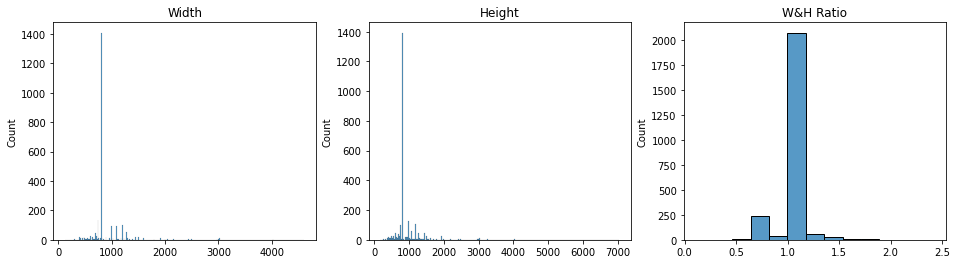

In [7]:
w_list = [x[0] for x in results]
h_list = [x[1] for x in results]

import seaborn as sns
f, ax = plt.subplots(1,3, figsize=(16,4))
sns.histplot(w_list, ax=ax[0], palette=sns.light_palette("seagreen", as_cmap=True)).set_title('Width');
sns.histplot(h_list, ax=ax[1], palette=sns.color_palette("RdPu", 10)).set_title('Height');
sns.histplot(np.array(w_list)/np.array(h_list), ax=ax[2], palette=sns.color_palette("RdPu", 10)).set_title('W&H Ratio');

大部分都是 `800*800` 的 尺寸，少部分会非常大

# 统计小目标的比例

In [8]:
from pycocotools.coco import COCO
json_path = osp.join(root, 'annotations', 'instances_train2017.json')
coco = COCO(json_path)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [9]:
print('bbox 小目标(area<%3)占比 统计')
class_names = []
wh_ratios_cls = []
for cat_id in coco.cats:
    wh_ratios = []
    for ann_id in coco.getAnnIds(catIds=[cat_id]):
        ann = coco.anns[ann_id]
        image_id = ann['image_id']
        w_ratio = ann['bbox'][2] / coco.imgs[image_id]['width']
        h_ratio = ann['bbox'][3] / coco.imgs[image_id]['height']
        wh_ratios.append([w_ratio, h_ratio])
    wh_ratios = np.array(wh_ratios)
    wh_ratios[:, -1] = wh_ratios[:, 0] * wh_ratios[:, 1]
    # print(coco.cats[cat_id]['name'], (wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])
    class_names.append(coco.cats[cat_id]['name'])
    wh_ratios_cls.append((wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])

wh_ratios = []
for _, ann in coco.anns.items():
    image_id = ann['image_id']
    w_ratio = ann['bbox'][2] / coco.imgs[image_id]['width']
    h_ratio = ann['bbox'][3] / coco.imgs[image_id]['height']
    wh_ratios.append([w_ratio, h_ratio])
wh_ratios = np.array(wh_ratios)
wh_ratios[:, -1] = wh_ratios[:, 0] * wh_ratios[:, 1]
# print('all ', (wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])
class_names.append('all')
wh_ratios_cls.append((wh_ratios[:,-1]<0.03).sum() / wh_ratios.shape[0])

from prettytable import PrettyTable
table_data = PrettyTable()
table_data.add_column('class', class_names)
table_data.add_column('small object ratio', wh_ratios_cls)
print(table_data.get_string())

bbox 小目标(area<%3)占比 统计
+------------------------+---------------------+
|         class          |  small object ratio |
+------------------------+---------------------+
|         冰墩墩         | 0.35398230088495575 |
|       Sanyo/三洋       |         1.0         |
|     Eifini/伊芙丽      |         1.0         |
|      PSALTER/诗篇      |  0.9636363636363636 |
|        Beaster         |       0.84375       |
|        ON/昂跑         |  0.9878048780487805 |
|     BYREDO/柏芮朵      |  0.9568965517241379 |
|         Ubras          |         0.98        |
|       Eternelle        |  0.6326530612244898 |
| PERFECT DIARY/完美日记 |  0.8918918918918919 |
|         花西子         |  0.9897959183673469 |
|     Clarins/娇韵诗     |  0.9734513274336283 |
|   L'occitane/欧舒丹    |  0.9716312056737588 |
|     Versace/范思哲     |  0.8235294117647058 |
|     Mizuno/美津浓      |  0.7520661157024794 |
|      Lining/李宁       |         0.95        |
|    DOUBLE STAR/双星    |  0.5416666666666666 |
|     YONEX/尤尼克斯     |  0.847560975

小目标(area<%3) 占据了大部分

# bbox长宽比

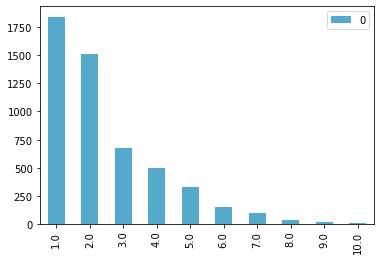

In [10]:
# refer: https://zhuanlan.zhihu.com/p/108885033
bbox_wh = [round(max(ann['bbox'][2], ann['bbox'][3]) / min(ann['bbox'][2], ann['bbox'][3]), 0) for _, ann in coco.anns.items()]
import pandas as pd
bbox_wh_unique = list(set(bbox_wh))
bbox_wh_count=[bbox_wh.count(i) for i in bbox_wh_unique]
k = 10
wh_df = pd.DataFrame(bbox_wh_count[:k], index=bbox_wh_unique[:k])
wh_df.plot(kind='bar',color="#55aacc")
plt.show()

In [12]:
print(type(coco.anns))

<class 'dict'>


In [14]:
print(dir(coco))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'annToMask', 'annToRLE', 'anns', 'catToImgs', 'cats', 'createIndex', 'dataset', 'download', 'getAnnIds', 'getCatIds', 'getImgIds', 'imgToAnns', 'imgs', 'info', 'loadAnns', 'loadCats', 'loadImgs', 'loadNumpyAnnotations', 'loadRes', 'showAnns']


In [25]:
cats = coco.loadCats(1)               #采用loadCats函数获取序号对应的类别名称
print(f'"1" 对应的类别名称: {cats}')
imgIds = coco.getImgIds(catIds=[1])    #采用getImgIds函数获取满足特定条件的图片（交集），获取包含person的所有图片
print(f'包含 冰墩墩的图片共有：{len(imgIds)}张')
imgId = imgIds[10]
imgInfo = coco.loadImgs(imgId)[0]

"1" 对应的类别名称: [{'id': 1, 'name': '冰墩墩'}]
包含 冰墩墩的图片共有：50张


图像2442的信息如下：
{'height': 600, 'width': 600, 'id': 2442, 'file_name': '55396f511d7325a09749a19c56ff91d0.jpg'}
im.shape:(600, 600, 3)


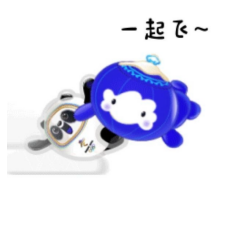

图像2442包含1个ann对象，分别是:
[5070]
anns:[{'id': 5070, 'image_id': 2442, 'category_id': 1, 'segmentation': [[48, 188, 48, 308.5, 48, 429, 185.5, 429, 323, 429, 323, 308.5, 323, 188, 185.5, 188]], 'bbox': [48, 188, 275, 241], 'iscrowd': 0, 'area': 66792}]


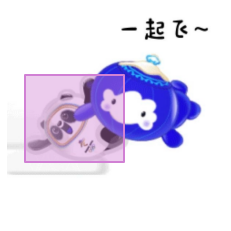

ann5070对应的mask如下：


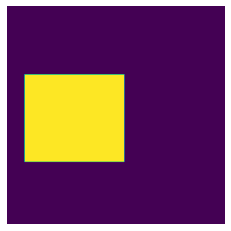

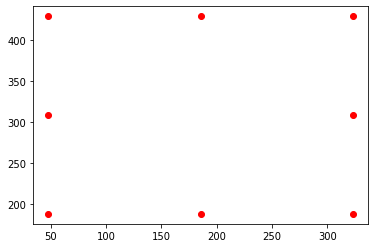

In [50]:

#4、将图片进行可视化
imgId = imgIds[10]
imgInfo = coco.loadImgs(imgId)[0]
print(f'图像{imgId}的信息如下：\n{imgInfo}')


imPath = os.path.join(root, 'images', imgInfo['file_name'])                     
im = cv2.imread(imPath)
print('im.shape:{}'.format(im.shape))
plt.axis('off')
plt.imshow(im)
plt.show()
anns = coco.loadAnns(annIds)



plt.imshow(im); plt.axis('off')
annIds = coco.getAnnIds(imgIds=imgInfo['id'])      # 获取该图像对应的anns的Id
print(f'图像{imgInfo["id"]}包含{len(anns)}个ann对象，分别是:\n{annIds}')
anns = coco.loadAnns(annIds)

print('anns:{}'.format(anns))
coco.showAnns(anns)
plt.show()

print(f'ann{annIds[0]}对应的mask如下：')
mask = coco.annToMask(anns[0])
plt.imshow(mask); plt.axis('off');
plt.show()

seg = anns[0]['segmentation'][0]
xs = []
ys = []
for i in range(len(seg)):
    if i % 2 == 0:
        xs.append(seg[i])
    else:
        ys.append(seg[i])
plt.scatter(xs, ys, color='red')
plt.show()

In [44]:
seg = anns[0]['segmentation'][0]
print(len(seg))

16
